# Modelo com Rebalanceamento e Custos de Transação 

In [2]:
import pandas as pd
import numpy as np
import random
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.environ import SolverFactory
import yfinance as yf
import matplotlib.pyplot as plt

In [6]:
# lista_ativos = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'WEGE3.SA',
#        'B3SA3.SA', 'BBAS3.SA', 'RENT3.SA', 'PRIO3.SA', 'SUZB3.SA', 'GGBR4.SA',
#        'CSNA3.SA', 'GOAU4.SA', 'RADL3.SA', 'ENEV3.SA', 'EQTL3.SA', 'FLRY3.SA',
#        'HAPV3.SA', 'MGLU3.SA', '^BVSP']

# lista_ativos = [
# 'ABEV3.SA',
# 'ASAI3.SA',
# 'B3SA3.SA',
# 'BBAS3.SA',
# 'BBDC3.SA',
# 'BBDC4.SA',
# 'BBSE3.SA',
# 'BEEF3.SA',
# 'BPAC11.SA',
# 'BRAP4.SA',
# 'BRFS3.SA',
# 'BRKM5.SA',
# 'CCRO3.SA',
# 'CIEL3.SA',
# 'CMIG4.SA',
# 'COGN3.SA',
# 'CPFE3.SA',
# 'CPLE6.SA',
# 'CRFB3.SA',
# 'CSAN3.SA',
# 'CSNA3.SA',
# 'CVCB3.SA',
# 'CYRE3.SA',
# 'ECOR3.SA',
# 'EGIE3.SA',
# 'ELET3.SA',
# 'ELET6.SA',
# 'EMBJ3.SA',
# 'ENEV3.SA',
# 'ENGI11.SA',
# 'EQTL3.SA',
# 'EZTC3.SA',
# 'FLRY3.SA',
# 'GGBR4.SA',
# 'GOAU4.SA',
# 'GOLL4.SA',
# 'HAPV3.SA',
# 'HYPE3.SA',
# 'IRBR3.SA',
# 'ITSA4.SA',
# 'ITUB4.SA',
# 'JBSS3.SA',
# 'JHSF3.SA',
# 'KLBN11.SA',
# 'LREN3.SA',
# 'MGLU3.SA',

# ]
# lista_ativos = ["VIVT3", "SBSP3", "RDOR3", "SUZB3", "EMBJ3", "BBSE3", "TIMS3", "RENT3", "CPFE3", "CXSE3", "EQTL3", "PRIO3", "RADL3", "ENEV3", "GGBR3", "NEOE3", "EGIE3", "VBBR3", "CMIG4", "JBSS3", "PSSA3", "MOTV3", "UGPA3", "RAIL3", "BRFS3", "CMIN3", "ENGI11", "MBRF3", "KLBN11", "TOTS3", "CSMG3", "ISAE4", "MRFG3", "CRFB3", "MULT3", "CGAS3", "BPAN4", "REDE3", "ALOS3", "LREN3", "TAEE11", "HYPE3", "SAPR11", "GGPS3", "CYRE3", "CEGR3", "EQPA3", "SMFT3", "GMAT3", "ASAI3", "CURY3", "ALUP11", "GOAU4", "STBP3", "CEEB3", "BNBR3", "ENMT4", "FLRY3", "ALPA4", "DIRR3", "BRAP4", "BRAV3", "MDIA3", "EKTR3", "CASN3", "TTEN3", "MGLU3", "IGTI3", "POMO4", "SLCE3", "BRSR6", "SRNA3", "UNIP6", "ECOR3", "COGN3", "VIVA3", "ORVR3", "WHRL4", "JHSF3", "BMEB4", "FRAS3", "ABCB4", "ODPV3", "VULC3", "CLSC4", "RIAA3", "AZZA3", "SMTO3", "SHUL4", "DXCO3", "VAMO3", "BAZA3", "PGMN3", "IGTA3", "MOVI3", "LEVE3", "IRBR3", "CBEE3", "ELMD3", "EZTC3", "GRND3", "INTB3", "TEND3", "CEAB3", "YDUQ3", "LAVV3", "MILS3", "MDNE3", "LOGN3", "COCE5", "RECV3", "FESA4", "PLPL3", "GEPA4", "EMAE4", "SBFG3", "BEES3", "PINE4", "BMGB4", "TGMA3", "AUAU3", "BLAU3", "TFCO4", "BSLI3", "CSED3", "LOGG3", "JSLG3", "CSRN3", "PNVL3", "CAML3", "CEBR3", "RAPT4", "RANI3", "BMOB3", "FIQE3", "VTRU3", "EUCA3", "ANIM3", "MATD3", "OPCT3", "VLID3", "LIGT3", "TRIS3", "KEPL3", "EVEN3", "SEER3", "MYPK3", "WIZC3", "OFSA3", "PRNR3", "TELB3", "SOJA3", "PFRM3", "FRIO3", "BPAR3", "DEXP3", "BGIP4", "JALL3", "WLMM3", "PATI3", "MELK3", "CSUD3", "ROMI3", "TASA3", "MOAR3", "PEAB3", "SYNE3", "ALLD3", "QUAL3", "CGRA4", "MERC4", "TKNO4", "VITT3", "MTSA4", "TECN3", "AMAR3", "AFLT3", "VSTE3", "MTRE3", "HBOR3", "DOHL4", "ESPA3", "PTNT4", "CAMB3", "CASH3", "HBRE3", "DMVF3", "EALT4", "CTKA4", "MNPR3", "LPSB3", "ETER3", "JOPA3", "BAUH4", "HBTS5", "BALM3", "AHEB3", "MGEL4", "RSUL4", "ODER4", "BMKS3", "SOND6", "CEDO3", "BMIN4", "LUXM4", "CALI3", "MMAQ3", "NUTR3", "MWET4", "FIGE3", "CATA3", "BRBI11"]

lista_ativos = ['VIVT3.SA', 'SBSP3.SA', 'RDOR3.SA', 'SUZB3.SA', 'EMBJ3.SA', 'BBSE3.SA', 'TIMS3.SA', 'RENT3.SA', 'CPFE3.SA', 'CXSE3.SA', 'EQTL3.SA', 'PRIO3.SA', 'RADL3.SA', 'ENEV3.SA', 'GGBR3.SA', 'NEOE3.SA', 'EGIE3.SA', 'VBBR3.SA', 'CMIG4.SA', 'JBSS3.SA', 'PSSA3.SA', 'MOTV3.SA', 'UGPA3.SA', 'RAIL3.SA', 'BRFS3.SA', 'CMIN3.SA', 'ENGI11.SA', 'MBRF3.SA', 'KLBN11.SA', 'TOTS3.SA', 'CSMG3.SA', 'ISAE4.SA', 'MRFG3.SA', 'CRFB3.SA', 'MULT3.SA', 'CGAS3.SA', 'BPAN4.SA', 'REDE3.SA', 'ALOS3.SA', 'LREN3.SA', 'TAEE11.SA', 'HYPE3.SA', 'SAPR11.SA', 'GGPS3.SA', 'CYRE3.SA', 'CEGR3.SA', 'EQPA3.SA', 'SMFT3.SA', 'GMAT3.SA', 'ASAI3.SA', 'CURY3.SA', 'ALUP11.SA', 'GOAU4.SA', 'STBP3.SA', 'CEEB3.SA', 'BNBR3.SA', 'ENMT4.SA', 'FLRY3.SA', 'ALPA4.SA', 'DIRR3.SA', 'BRAP4.SA', 'BRAV3.SA', 'MDIA3.SA', 'EKTR3.SA', 'CASN3.SA', 'TTEN3.SA', 'MGLU3.SA', 'IGTI3.SA', 'POMO4.SA', 'SLCE3.SA', 'BRSR6.SA', 'SRNA3.SA', 'UNIP6.SA', 'ECOR3.SA', 'COGN3.SA', 'VIVA3.SA', 'ORVR3.SA', 'WHRL4.SA', 'JHSF3.SA', 'BMEB4.SA', 'FRAS3.SA', 'ABCB4.SA', 'ODPV3.SA', 'VULC3.SA', 'CLSC4.SA', 'RIAA3.SA', 'AZZA3.SA', 'SMTO3.SA', 'SHUL4.SA', 'DXCO3.SA', 'VAMO3.SA', 'BAZA3.SA', 'PGMN3.SA', 'IGTA3.SA', 'MOVI3.SA', 'LEVE3.SA', 'IRBR3.SA', 'CBEE3.SA', 'ELMD3.SA', 'EZTC3.SA', 'GRND3.SA', 'INTB3.SA', 'TEND3.SA', 'CEAB3.SA', 'YDUQ3.SA', 'LAVV3.SA', 'MILS3.SA', 'MDNE3.SA', 'LOGN3.SA', 'COCE5.SA', 'RECV3.SA', 'FESA4.SA', 'PLPL3.SA', 'GEPA4.SA', 'EMAE4.SA', 'SBFG3.SA', 'BEES3.SA', 'PINE4.SA', 'BMGB4.SA', 'TGMA3.SA', 'AUAU3.SA', 'BLAU3.SA', 'TFCO4.SA', 'BSLI3.SA', 'CSED3.SA', 'LOGG3.SA', 'JSLG3.SA', 'CSRN3.SA', 'PNVL3.SA', 'CAML3.SA', 'CEBR3.SA', 'RAPT4.SA', 'RANI3.SA', 'BMOB3.SA', 'FIQE3.SA', 'VTRU3.SA', 'EUCA3.SA', 'ANIM3.SA', 'MATD3.SA', 'OPCT3.SA', 'VLID3.SA', 'LIGT3.SA', 'TRIS3.SA', 'KEPL3.SA', 'EVEN3.SA', 'SEER3.SA', 'MYPK3.SA', 'WIZC3.SA', 'OFSA3.SA', 'PRNR3.SA', 'TELB3.SA', 'SOJA3.SA', 'PFRM3.SA', 'FRIO3.SA', 'BPAR3.SA', 'DEXP3.SA', 'BGIP4.SA', 'JALL3.SA', 'WLMM3.SA', 'PATI3.SA', 'MELK3.SA', 'CSUD3.SA', 'ROMI3.SA', 'TASA3.SA', 'MOAR3.SA', 'PEAB3.SA', 'SYNE3.SA', 'ALLD3.SA', 'QUAL3.SA', 'CGRA4.SA', 'MERC4.SA', 'TKNO4.SA', 'VITT3.SA', 'MTSA4.SA', 'TECN3.SA', 'AMAR3.SA', 'AFLT3.SA', 'VSTE3.SA', 'MTRE3.SA', 'HBOR3.SA', 'DOHL4.SA', 'ESPA3.SA', 'PTNT4.SA', 'CAMB3.SA', 'CASH3.SA', 'HBRE3.SA', 'DMVF3.SA', 'EALT4.SA', 'CTKA4.SA', 'MNPR3.SA', 'LPSB3.SA', 'ETER3.SA', 'JOPA3.SA', 'BAUH4.SA', 'HBTS5.SA', 'BALM3.SA', 'AHEB3.SA', 'MGEL4.SA', 'RSUL4.SA', 'ODER4.SA', 'BMKS3.SA', 'SOND6.SA', 'CEDO3.SA', 'BMIN4.SA', 'LUXM4.SA', 'CALI3.SA', 'MMAQ3.SA', 'NUTR3.SA', 'MWET4.SA', 'FIGE3.SA', 'CATA3.SA', 'BRBI11.SA']

# lista_ativos = random.sample(lista_ativos,20)

print("-----------COMEÇANDO---------")
print("Tamanho da lista de ativos: ",len(lista_ativos))

#DADOS DOS ATIVOS
mydf = pd.DataFrame()
for ativo in lista_ativos:
    mydf[ativo] = yf.download(ativo, period="2y")["Close"]

retornos_ativos2 = (mydf / mydf.shift(1))-1

#DADOS DO IBOV
mydf_ibov = pd.DataFrame()
mydf_ibov['IBOV'] = yf.download('^BVSP', period="2y")["Close"]


retorno_ibov2 = (mydf_ibov / mydf_ibov.shift(1)) - 1



#--------------- MANUS CONSERTANDO
# DICA: Remova os NaNs que o shift(1) cria na primeira linha
# retornos_ativos = retornos_ativos.dropna()
# retorno_ibov = retorno_ibov.dropna()

# Alinhando os dados para garantir que tenham o mesmo número de linhas
# retornos_ativos = retornos_ativos.loc[common_index]
# retorno_ibov = retorno_ibov.loc[common_index]

-----------COMEÇANDO---------
Tamanho da lista de ativos:  212


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
# ESSA LINHA É EXECUTADA UMA VEZ, PARA EXCLUIR A PRIMEIRA LINHA DO DF
retornos_ativos2 = retornos_ativos2.drop(index=['2024-02-20'])

In [93]:
print(retornos_ativos2.shape)
retornos_ativos2 = retornos_ativos2.dropna(axis=0, how='all')
print(retornos_ativos2.shape)
retornos_ativos2 = retornos_ativos2.dropna(axis=1, how='all')
print(retornos_ativos2.shape)
# print(retornos_ativos2.isnull().sum())
null_ativos2 = retornos_ativos2.isnull().sum()
# print(len(null_ativos2[null_ativos2<5].index))
# print(len(null_ativos2.index))
ativos2_com_null_menor_5 = null_ativos2[null_ativos2<5].index
(retornos_ativos2[ativos2_com_null_menor_5]==0).sum()<20

(501, 202)
(501, 202)
(501, 202)


VIVT3.SA      True
SBSP3.SA      True
RDOR3.SA      True
SUZB3.SA      True
BBSE3.SA      True
             ...  
MMAQ3.SA     False
NUTR3.SA     False
MWET4.SA     False
FIGE3.SA     False
BRBI11.SA     True
Length: 193, dtype: bool

In [ ]:
retornos_ativos2.filter()

ValueError: Index data must be 1-dimensional

In [ ]:


retornos_ativos = retornos_ativos2.dropna(axis=1, how='any').dropna(axis=0, how='any')
retorno_ibov = retorno_ibov2.dropna(axis=1, how='any').dropna(axis=0, how='any')
common_index = retornos_ativos.index.intersection(retorno_ibov.index)
print(common_index)
retorno_ibov = retorno_ibov.loc[common_index]
retornos_ativos = retornos_ativos.loc[common_index]
metade_ativo = len(retornos_ativos)//2
metade_ibov = len(retorno_ibov)//2

DatetimeIndex(['2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
               '2024-03-01', '2024-03-04',
               ...
               '2026-02-05', '2026-02-06', '2026-02-09', '2026-02-10',
               '2026-02-11', '2026-02-12', '2026-02-13', '2026-02-18',
               '2026-02-19', '2026-02-20'],
              dtype='datetime64[ns]', name='Date', length=502, freq=None)


In [5]:
retorno_ibov

""
Date
2024-02-20
2024-02-21
2024-02-22
2024-02-23
2024-02-26
...
2026-02-12
2026-02-13
2026-02-18


In [ ]:
# Metades Atvios
retornos_ativos_primeira_metade = retornos_ativos.iloc[0:metade_ativo]
retornos_ativos_segunda_metade = retornos_ativos.iloc[metade_ativo:]

# Metade ibov
retornos_ibov_primeira_metade = retorno_ibov.iloc[0:metade_ibov]
retornos_ibov_segunda_metade = retorno_ibov.iloc[metade_ibov:]


# TEM QUE SER DICIONARIO
# Transformar os df em dicionarios, quando for 2 dimensoes dict[0,1] e 1 dimensão dict[0]

# 1º parte 
dicio_ativos = {}
for t in range(len(retornos_ativos_primeira_metade)):
    for a in range(len(retornos_ativos_primeira_metade.columns)):
        dicio_ativos[t,a] = retornos_ativos_primeira_metade.iloc[t,a]

dicio_ibov = {}
for t in range(len(retornos_ibov_primeira_metade)):
    dicio_ibov[t] = retornos_ibov_primeira_metade['IBOV'].iloc[t]

# 2º parte
dicio_ativos_2 = {}
for t in range(len(retornos_ativos_segunda_metade)):
    for a in range(len(retornos_ativos_segunda_metade.columns)):
        dicio_ativos_2[t,a] = retornos_ativos_segunda_metade.iloc[t,a]

dicio_ibov_2 = {}
for t in range(len(retornos_ibov_segunda_metade)):
    dicio_ibov_2[t] = retornos_ibov_segunda_metade['IBOV'].iloc[t]



In [ ]:
# ------ CRIAÇÃO DO MODELO
model = pyo.ConcreteModel()

# Definir RangeSet que serão usados para fazer o For
# "A" para quantidade de ativos, virão da quantidade de colunas len(.columns)
# "T" para quantidade de dias analisados, que podem ser observados pela quantidade de linhas len()
model.A = pyo.RangeSet(0, len(retornos_ativos_primeira_metade.columns)-1)
model.T = pyo.RangeSet(0, len(retornos_ibov_primeira_metade)-1)

# Definição de Parametros (são os Dataframes)
#Quais Df eu tenho? retornos_ativos_primeira_metade e retornos_ibov_primeira_metade EM DICIONARIO

model.ATIVOS_PRIMEIRA_METADE = pyo.Param(model.T,model.A, initialize = dicio_ativos)
model.IBOV_PRIMEIRA_METADE = pyo.Param(model.T, initialize = dicio_ibov)

# Definicindo as variáveis
# nesse projeto será feito a mesma coisa do que o mip com restrição de cardinalidade, 
# mas será feito primeiro na primeira metade, e após será feito o rebalanceamento
#variavel x para peso, y para cardinalidade

model.x = pyo.Var(model.A, bounds=(0,1))
model.y = pyo.Var(model.A, within=pyo.Binary)

# Definindo função objetivo
# a ideia na primeira parte é reduzir o erro quadrático
def func_objetivo_1(model):
    return sum(
        (sum(model.ATIVOS_PRIMEIRA_METADE[t,a] * model.x[a] for a in model.A) - model.IBOV_PRIMEIRA_METADE[t])**2 for t in model.T
    )
model.obj1 = pyo.Objective(rule=func_objetivo_1, sense=pyo.minimize)

# Restrições
# soma dos pesos tem que ser igual a 1
# se y for 0 x nao é para ser 0 
#observar as dicas para, regras globais e regras individuais, 
# regra individual: peso maximo para cada ativo é 0.12
# regra global, a soma dos pesos é 1

#REstricao 1 x só ativa se y = 1
def restr_vinculo_x_y(model, a):
    return model.x[a] <= model.y[a]
model.restr_vinculo_x_y = pyo.Constraint(model.A, rule=restr_vinculo_x_y)

#Restrição 2 soma peso 1
def soma_peso_1(model):
    return sum(model.x[a] for a in model.A) ==1
model.soma_peso_1 = pyo.Constraint(rule=soma_peso_1)

#Restrição 3 de cardinalidade, quantidade de ativos no total
def cardinalidade_15(model):
    return sum(
        model.y[a] for a in model.A
        ) <= 15
model.cardinalidade_15 = pyo.Constraint(rule=cardinalidade_15)

opt = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
resultado = opt.solve(model)
print("-------FIM----------")

## MOSTRANDO RESULTADO DA 1 PRIMEIRA PARTE

In [244]:
lsita_grande = []
for numero in range(len(retornos_ativos_primeira_metade.columns)):
    peso_ativo = pyo.value(model.x[numero])
    ativado = pyo.value(model.y[numero])
    lista = [peso_ativo, ativado]
    lsita_grande.append(lista)
    
final = pd.DataFrame(lsita_grande, columns=["peso_ativo","ativado"], index=retornos_ativos_primeira_metade.columns)
print(final[final['ativado']==1])

           peso_ativo  ativado
ABEV3.SA     0.039625      1.0
B3SA3.SA     0.047059      1.0
BBAS3.SA     0.081652      1.0
BBDC4.SA     0.063364      1.0
BPAC11.SA    0.061369      1.0
BRAP4.SA     0.130368      1.0
CMIG4.SA     0.032323      1.0
CSAN3.SA     0.043073      1.0
ECOR3.SA     0.028082      1.0
EMBJ3.SA     0.208432      1.0
FLRY3.SA     0.051482      1.0
GOAU4.SA     0.043457      1.0
ITSA4.SA     0.099563      1.0
KLBN11.SA    0.055763      1.0
MGLU3.SA     0.014389      1.0


In [245]:
df_final = final[final['ativado']==1]
# df_final.head()
ativos_selecionados = df_final.index
retornos_carteira= retornos_ativos_primeira_metade[ativos_selecionados]

carteira_otimizada = (retornos_carteira*df_final['peso_ativo']).sum(axis=1)
carteira_otimizada = 1 + carteira_otimizada
#criar a carteira equiponderada, com pesos iguais

carteira_equi = retornos_carteira.mean(axis=1)
carteira_equi = 1 + carteira_equi

93.8073002712566
86.7409760927355
98.9346962652791


C:\Users\DECIV\AppData\Local\Temp\ipykernel_3976\3421782161.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_otimizado[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_3976\3421782161.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_equi[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_3976\3421782161.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_ibov[-1])


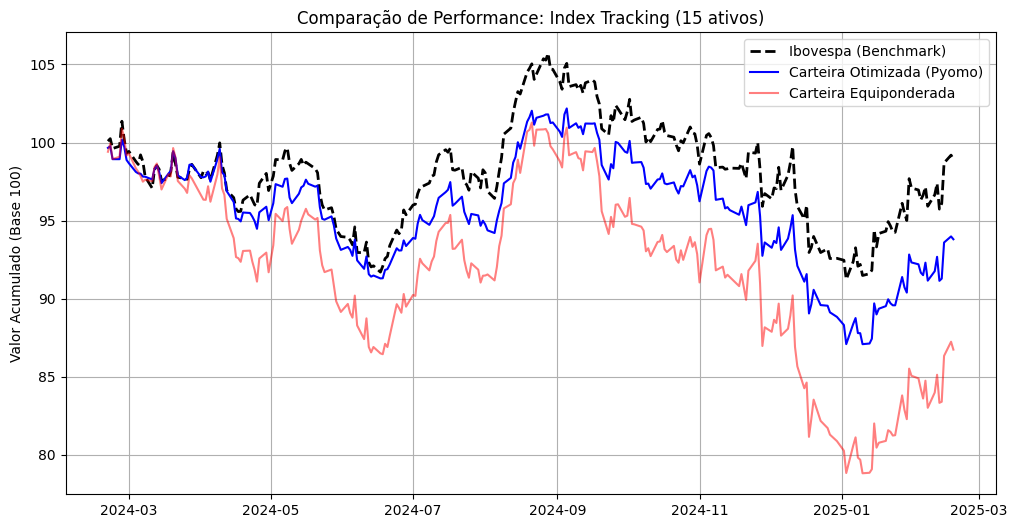

In [246]:
# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado = (carteira_otimizada).cumprod() * 100
acum_equi = (carteira_equi).cumprod() * 100
acum_ibov = (1 + retornos_ibov_primeira_metade['IBOV']).cumprod() * 100

print(acum_otimizado[-1])
print(acum_equi[-1])
print(acum_ibov[-1])

# 4. Plotar o Gráfico
plt.figure(figsize=(12, 6))
plt.plot(acum_ibov, label='Ibovespa (Benchmark)', color='black', linewidth=2, linestyle='--')
plt.plot(acum_otimizado, label='Carteira Otimizada (Pyomo)', color='blue')
plt.plot(acum_equi, label='Carteira Equiponderada', color='red', alpha=0.5)

plt.title('Comparação de Performance: Index Tracking (15 ativos)')
plt.ylabel('Valor Acumulado (Base 100)')
plt.legend()
plt.grid(True)
plt.show()

### -------- 2º parte -  REBALANCEAMENTO

In [247]:
pesos_anteriores = {a: pyo.value(model.x[a]) for a in model.A}
len(pesos_anteriores)

37

In [253]:
## a ideia aqui é Compra e Venda ,
## mas nao binária, ou seja, nao é 0 nao compra e 1 compra,
# é porcentagem, o quanto comprar e o quanto vender , envolvende uma custo de transação

#RESUMO DO QUE IRÁ ACONTECER
# | Situação            | $x\_{antigo}$ | $x\_{novo}$ | Compra | Venda | Custo Gerado    |
# | :------------------ | :-----------: | :---------: | :----: | :---: | :-------------- |
# | **Aumentar aposta** |      0.05     |     0.08    |  0.03  |  0.00 | Taxa sobre 0.03 |
# | **Diminuir aposta** |      0.10     |     0.04    |  0.00  |  0.06 | Taxa sobre 0.06 |
# | **Sair do ativo**   |      0.05     |     0.00    |  0.00  |  0.05 | Taxa sobre 0.05 |
# | **Entrar no ativo** |      0.00     |     0.07    |  0.07  |  0.00 | Taxa sobre 0.07 |

#criando modelo novo
model_B = pyo.ConcreteModel()

## RANGESET será usado do modelo antigo
model_B.T = pyo.RangeSet(0, len(retornos_ativos_segunda_metade)-1)
model_B.A = pyo.RangeSet(0, len(retornos_ativos_segunda_metade.columns)-1)
## PARAMETROS serão usados os dados do segundo semestre
## normalmente são usados os model dos RangeSet nos parâmetros
## nao tenho certeza que o rangeset do primeiro modelo está alinhado com a quantidade do segundo modelo, 
# por conta da segunda metade ter menos dados que a primeira, se der errado, vir aqui <------------
# AQUI È DICIONAAAAAAAAAARIO ----> nos parâmetros é dicionáaario!
model_B.ATIVOS_SEGUNDA_METADE = pyo.Param(model_B.T, model_B.A, initialize=dicio_ativos_2)
model_B.IBOV_SEGUNDA_METADE = pyo.Param(model_B.T, initialize = dicio_ibov_2)

#Definindo variáveis de compra e venda, que serão as usadas
model_B.x = pyo.Var(model_B.A, bounds=(0,1)) #novos pesos 
model_B.y = pyo.Var(model_B.A, within=pyo.Binary) #nova cardinalidade 
model_B.compra =pyo.Var(model_B.A, bounds=(0,1))
model_B.venda =pyo.Var(model_B.A, bounds=(0,1))
custo_taxa = 0.0003 # = 0.25%
tamanho_carteira_final = 20
#OBJETIVO
def func_objetivo_2(model_B):
    #como se trata de 2 momentos, o tracking e o custo de transação
    mse_2 = sum(
        (sum(model_B.ATIVOS_SEGUNDA_METADE[t,a] * model_B.x[a] for a in model_B.A) - model_B.IBOV_SEGUNDA_METADE[t])**2 
        for t in model_B.T
        )
    custo_transacao = sum(model_B.compra[a] + model_B.venda[a] for a in model_B.A) * custo_taxa

    return mse_2 + custo_transacao
    # return mse_2

model_B.obj = pyo.Objective(rule=func_objetivo_2, sense=pyo.minimize)

#Restrições
#mais importante se a compra e venda será usada

def regra_equilibrio(model_B, a):
    return model_B.x[a] == pesos_anteriores[a] + model_B.compra[a] - model_B.venda[a]

model_B.regra_equilibrio = pyo.Constraint(model_B.A, rule=regra_equilibrio)

#restrições de soma peso 1 ; de x só ser ativado se y = 1 ; de cardinalidade 15 para y

def model_B_soma_peso_1(model_B):
    return sum(
        model_B.x[a] for a in model_B.A
    ) == 1
model_B.model_B_soma_peso_1 = pyo.Constraint( rule=model_B_soma_peso_1)

def model_B_y_cardinalidade(model_B):
    return sum(
        model_B.y[a] for a in model_B.A
    ) <= tamanho_carteira_final
model_B.model_B_y_cardinalidade = pyo.Constraint(rule = model_B_y_cardinalidade)

def model_B_x_y(model_B, a):
    return model_B.x[a] <= model_B.y[a]
model_B.model_B_x_y = pyo.Constraint(model_B.A, rule = model_B_x_y)


In [249]:
opt_B = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
resultado = opt_B.solve(model_B)
print("-------FIM----------")

-------FIM----------


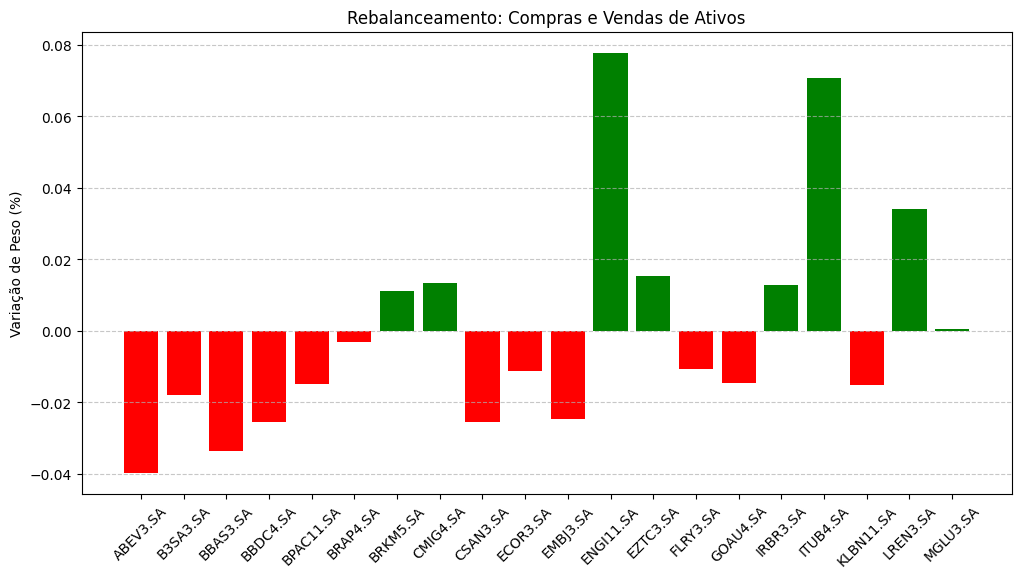

In [250]:
# Extrair os valores de compra e venda do model_B
mudancas_compra = []
mudancas_venda = []
mudancas = []
for a in range(len(retornos_ativos_segunda_metade.columns)):
    c = pyo.value(model_B.compra[a])
    v = pyo.value(model_B.venda[a])
   
    mudancas.append(c if c > 0.00001 else -v)

    
    # Se comprou, valor positivo; se vendeu, valor negativo
    mudancas_compra.append(c)
    mudancas_venda.append(v)

x_peso_final = []
y_ativado_final = []

for a in range(len(retornos_ativos_segunda_metade.columns)):
    lista_x = pyo.value(model_B.x[a])
    lista_y = pyo.value(model_B.y[a])

    x_peso_final.append(lista_x)
    y_ativado_final.append(lista_y)
    
lista_peso_anterior = df_final['peso_ativo'].tolist()
df_mudancas = pd.DataFrame({'Ativo': retornos_ativos_primeira_metade.columns,'Mudança': mudancas, 'Mudança_Compra': mudancas_compra,"Mudança_venda":mudancas_venda,'Ativado':y_ativado_final, "Peso_otimizado":x_peso_final})
# carteira_final['peso_anterior'] = lista_peso_anterior

df_mudancas2 = df_mudancas[df_mudancas['Mudança'].abs() > 0.0001] # Filtrar apenas o que mudou
carteira_final = df_mudancas[df_mudancas['Ativado']==1]


plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in df_mudancas2['Mudança']]
plt.bar(df_mudancas2['Ativo'], df_mudancas2['Mudança'], color=colors)
plt.xticks(rotation=45)
plt.title('Rebalanceamento: Compras e Vendas de Ativos')
plt.ylabel('Variação de Peso (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [251]:
print(df_final)
print(df_mudancas2)
print(carteira_final)

           peso_ativo  ativado
ABEV3.SA     0.039625      1.0
B3SA3.SA     0.047059      1.0
BBAS3.SA     0.081652      1.0
BBDC4.SA     0.063364      1.0
BPAC11.SA    0.061369      1.0
BRAP4.SA     0.130368      1.0
CMIG4.SA     0.032323      1.0
CSAN3.SA     0.043073      1.0
ECOR3.SA     0.028082      1.0
EMBJ3.SA     0.208432      1.0
FLRY3.SA     0.051482      1.0
GOAU4.SA     0.043457      1.0
ITSA4.SA     0.099563      1.0
KLBN11.SA    0.055763      1.0
MGLU3.SA     0.014389      1.0
        Ativo   Mudança  Mudança_Compra  Mudança_venda  Ativado  \
0    ABEV3.SA -0.039625        0.000000       0.039625     -0.0   
2    B3SA3.SA -0.017935        0.000000       0.017935      1.0   
3    BBAS3.SA -0.033657        0.000000       0.033657      1.0   
5    BBDC4.SA -0.025349        0.000000       0.025349      1.0   
8   BPAC11.SA -0.014860        0.000000       0.014860      1.0   
9    BRAP4.SA -0.003116        0.000000       0.003116      1.0   
10   BRKM5.SA  0.011252        0.01

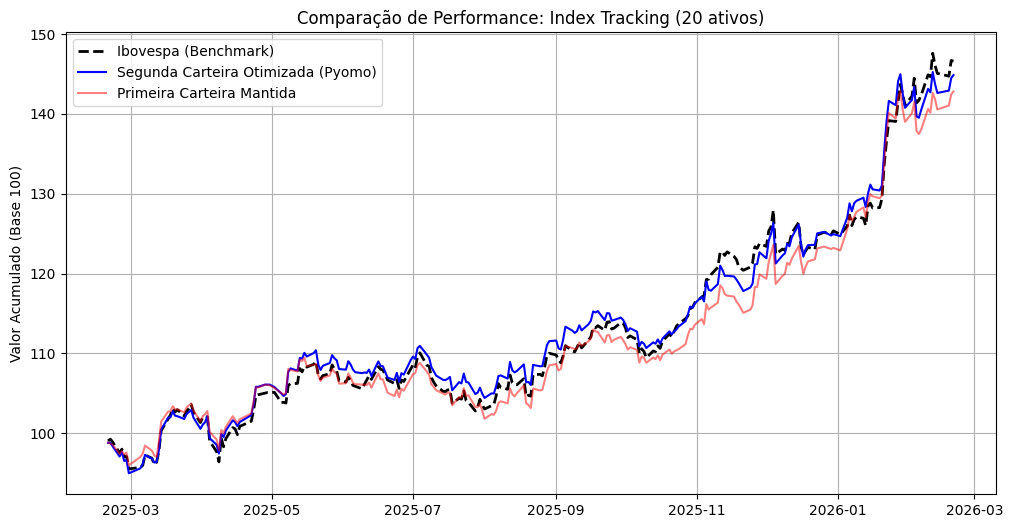

In [261]:
carteira_final2 = carteira_final['Peso_otimizado'].reset_index().drop(columns=['index']).set_index(carteira_final['Ativo'])
ativos_selecionados2 = carteira_final['Ativo'].tolist()
retornos_carteira2 = retornos_ativos_segunda_metade[ativos_selecionados2]
carteira_otimizada2 = 1 + (retornos_carteira2*carteira_final2['Peso_otimizado']).sum(axis=1)

ativos_carteira_primeira = df_final.index
retornos_carteira_primeira = retornos_ativos_segunda_metade[ativos_carteira_primeira]
carteira_primeira = 1 +(retornos_carteira_primeira*df_final['peso_ativo']).sum(axis=1)

# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado2 = (carteira_otimizada2).cumprod() *100
acum_otimizado1 = (carteira_primeira).cumprod() *100
# acum_equi = (carteira_equi).cumprod() * 100
acum_ibov2 = (1 + retornos_ibov_segunda_metade['IBOV']).cumprod() * 100

# print(acum_otimizado2[-1])
# # print(acum_equi[-1])
# print(acum_ibov[-1])

# 4. Plotar o Gráfico
plt.figure(figsize=(12, 6))
plt.plot(acum_ibov2, label='Ibovespa (Benchmark)', color='black', linewidth=2, linestyle='--')
plt.plot(acum_otimizado2, label='Segunda Carteira Otimizada (Pyomo)', color='blue')
plt.plot(acum_otimizado1, label='Primeira Carteira Mantida', color='red', alpha=0.5)

texto_titulo = f'Comparação de Performance: Index Tracking ({tamanho_carteira_final} ativos)'
plt.title(texto_titulo)
plt.ylabel('Valor Acumulado (Base 100)')
plt.legend()
plt.grid(True)
plt.show()